### Train

In [1]:
import pandas as pd
import numpy as np

In [15]:
from utils.stock_data import StockData
from utils.format_data import generate_target_context_idx_pairs

PERIODS = [1]
TRAIN_PCT = 1
CONTEXT_SIZE = 32

tgt_context_sets = []
for period in PERIODS:
    print(f"Running for period {period}")
    data = StockData(
        daily_returns_path="data/nsenbse-data.csv",
        extras_path="data/historical-stocks.csv"
    )
    data.change_returns_period(period)
    data.train_test_split(TRAIN_PCT)

    tgt_context_sets += generate_target_context_idx_pairs(
        data.train_returns_df,
        context_size=CONTEXT_SIZE,
        verbose=True,
        iqr_noise_reduction=True,
    )
    print("="*20)
print(f"Total number of target context sets: {len(tgt_context_sets)}")

Running for period 1
No change made because period entered is 1


100%|██████████| 1119/1119 [00:10<00:00, 107.55it/s]

Total number of target context sets: 2238795


In [16]:
data

StockData(
    directory=data/nsenbse-data.csv,
    num_stocks=1119,
    num_sectors=11,
    period=1
)

In [17]:
ticker = "HDFCBANK.NS"
i = data.ticker2idx[ticker]
temp = np.array([xi[1] for xi in tgt_context_sets if xi[0] == i]).flatten()
print(
    f"The most commonly co-occurring stocks with {ticker} are: {[data.idx2ticker[xi] for xi in pd.Series(temp).value_counts().index][:5]}"
)

The most commonly co-occurring stocks with HDFCBANK.NS are: ['HDFCBANK.BO', 'KOTAKBANK.NS', 'AXISBANK.NS', 'KOTAKBANK.BO', 'TCS.BO']


In [18]:
from utils.model import NSE2Vec

EMBEDDING_DIM = 128
model = NSE2Vec(
    n_time_series=len(data.tickers), embedding_dim=EMBEDDING_DIM
)

model

NSE2Vec(
  (embeddings): Embedding(1119, 128)
)

In [19]:
from utils.evaluate import evaluate_embeddings
from utils.train import train

EPOCHS = 5

model, losses = train(
    n_time_series=len(data.tickers),
    tgt_context_sets=tgt_context_sets,
    model=model,
    epochs=EPOCHS,
    batch_size=128,
    early_stopping=False,
    device="mps",
    learning_rate = 1e-3,
    verbose=True,
    sectors=data.sectors
)

Training embeddings...


 20%|██        | 1/5 [02:04<08:17, 124.46s/it]

All labels in y_pred?: True
Precision Score: 0.73
Recall Score: 0.71
F1 Score: 0.72
Accuracy Score: 0.71
Accuracy Score Top-3: 0.86


 40%|████      | 2/5 [04:19<06:32, 130.73s/it]

All labels in y_pred?: True
Precision Score: 0.76
Recall Score: 0.75
F1 Score: 0.75
Accuracy Score: 0.75
Accuracy Score Top-3: 0.87


 60%|██████    | 3/5 [06:33<04:24, 132.27s/it]

All labels in y_pred?: True
Precision Score: 0.75
Recall Score: 0.73
F1 Score: 0.74
Accuracy Score: 0.73
Accuracy Score Top-3: 0.88


 80%|████████  | 4/5 [08:42<02:10, 130.99s/it]

All labels in y_pred?: True
Precision Score: 0.74
Recall Score: 0.74
F1 Score: 0.74
Accuracy Score: 0.74
Accuracy Score Top-3: 0.91


100%|██████████| 5/5 [10:48<00:00, 129.75s/it]

All labels in y_pred?: True
Precision Score: 0.79
Recall Score: 0.78
F1 Score: 0.78
Accuracy Score: 0.78
Accuracy Score Top-3: 0.9


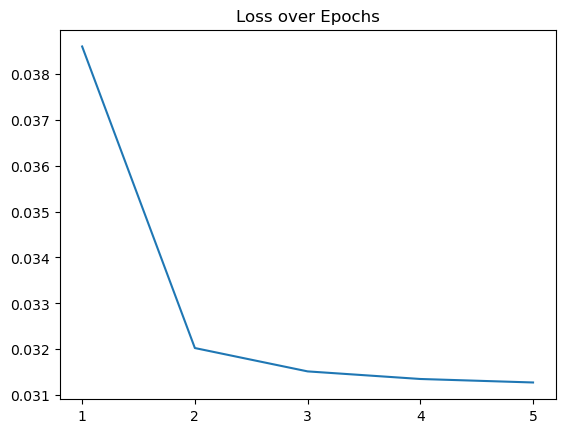

In [20]:
import matplotlib.pyplot as plt

sub_losses = losses[:]

plt.plot(range(1, len(sub_losses)+1), sub_losses)
plt.title("Loss over Epochs")
plt.xticks(range(1, len(sub_losses)+1, max(1, len(sub_losses)//10)))
plt.show()

In [21]:
model.save_model("nsenbse2vec.pt")

### Evaluate

In [22]:
model = NSE2Vec(n_time_series=len(data.tickers), embedding_dim=128).load_model("nsenbse2vec.pt")

In [23]:
evaluate_embeddings(model.embeddings.weight.detach().cpu().numpy(), sectors=data.sectors, top_k_accuracy=True, smote=True, n_splits=5)

All labels in y_pred?: True
Precision Score: 0.75
Recall Score: 0.76
F1 Score: 0.75
Accuracy Score: 0.76
Accuracy Score Top-3: 0.9


#### Results
| Data | Train Epochs | Accuracy | Accuracy (top 3) |
| --- | --- | --- | --- |
| NSE+BSE | 5 | 0.76 | 0.9 |
| NSE | 5 | 0.75 | 0.9 |

In [31]:
from utils.visualize import visualize_embeddings

visualize_embeddings(
    embedding_matrix=model.embeddings.weight.detach().cpu().numpy(),
    tickers=data.tickers,
    industries=data.industries,
    sectors=data.sectors,
    names=data.tickers,
    dimensions=2,
    reduced=True,
    method="PCA",
    return_df=False,
    rand_state=None,
)

In [25]:
embeddings_npy = model.embeddings.weight.detach().numpy()

embeddings_dict = {}

for idx, stock_name in enumerate(data.daily_returns_df.columns):
    embeddings_dict[stock_name] = embeddings_npy[idx]

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

def find_k_closest(ticker: str, k: int = 3):
    if ticker not in embeddings_dict.keys():
        raise ValueError(f"Stock name '{ticker}' not found in the list of stock names.")
    
    stock_index = list(embeddings_dict.keys()).index(ticker)

    similarity_matrix = cosine_similarity(list(embeddings_dict.values()))

    similarity_scores = similarity_matrix[stock_index]

    similar_indices = np.argsort(-similarity_scores)[1:k+1]

    similar_stocks = [(list(embeddings_dict.keys())[i], similarity_scores[i]) for i in similar_indices]
    
    return similar_stocks

In [34]:
find_k_closest("HDFCBANK.NS")

[('HDFCBANK.BO', 0.9760017),
 ('KOTAKBANK.NS', 0.3040996),
 ('KOTAKBANK.BO', 0.29088178)]